# Homework 1

### Author:Xuechun Wang
### Net ID: XW240

## Problem 1.1

Use LASSO regression to predict Salary from the other numeric predictors. Create a visualization of the coeffcient trajectories. Comment on which are the final three predictors that remain in the model. Use cross-validation to find the optimal value of the regularization penality. How many predictors are left in that model?

In [2]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')

In [3]:
# Read in the data set:
url='https://gist.githubusercontent.com/keeganhines/59974f1ebef97bbaa44fb19143f90bad/raw/d9bcf657f97201394a59fffd801c44347eb7e28d/Hitters.csv'
mydata = pd.read_csv(url,sep=",")
mydata.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


In [4]:
# Remove the missing values from the data set.
mydata = mydata.dropna().dropna().iloc[:,1:]
#mydata.info()
dummies = pd.get_dummies(mydata[['League', 'Division', 'NewLeague']])
y = mydata.Salary
# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_temp = mydata.drop(['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')
# Define the feature set X.
X = pd.concat([X_temp, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis = 1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 19 columns):
AtBat          263 non-null float64
Hits           263 non-null float64
HmRun          263 non-null float64
Runs           263 non-null float64
RBI            263 non-null float64
Walks          263 non-null float64
Years          263 non-null float64
CAtBat         263 non-null float64
CHits          263 non-null float64
CHmRun         263 non-null float64
CRuns          263 non-null float64
CRBI           263 non-null float64
CWalks         263 non-null float64
PutOuts        263 non-null float64
Assists        263 non-null float64
Errors         263 non-null float64
League_N       263 non-null uint8
Division_W     263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: float64(16), uint8(3)
memory usage: 35.7 KB


Text(0,0.5,'weights')

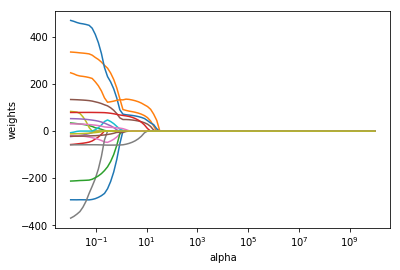

In [5]:
# Generate a sequence of alphas
alphas = 10**np.linspace(10,-2,100)*0.5
# Conduct lasso regression:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X), y)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

From the plot above, we could conclud that when the tuning parameter alpha is bigger than 10, there are only about 5 variable left in the model with some of the coefficients are exactly equal to zero. Let's set alpha to 10:

In [6]:
lasso.set_params(alpha=10)
lasso.fit(scale(X), y)
pd.Series(lasso.coef_, index=X.columns)

AtBat           0.000000
Hits           14.839356
HmRun           0.000000
Runs            0.000000
RBI             0.000000
Walks           0.000000
Years           0.000000
CAtBat          0.000000
CHits           0.000000
CHmRun          0.000000
CRuns          25.229625
CRBI           65.994753
CWalks          0.000000
PutOuts         0.000000
Assists         0.000000
Errors          0.000000
League_N        0.000000
Division_W     -0.000000
NewLeague_N     0.000000
dtype: float64

#### The three varibles left are "Hits", "CRuns" and "CRBI".

We now perform 10-fold cross-validation to choose the best alpha, refit the model, and compute the associated test error:

In [12]:
# Split data into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
#mean_squared_error(y_test, lasso.predict(X_test))
# Some of the coefficients are now reduced to exactly zero.
print(pd.Series(lasso.coef_, index=X.columns))

print("\nThe optimal value of alpha: ")
print(lassocv.alpha_)

AtBat           -1.465507
Hits             5.205001
HmRun            4.017897
Runs             0.000000
RBI             -0.000000
Walks            5.742103
Years           -0.000000
CAtBat          -0.000000
CHits            0.086968
CHmRun           0.000000
CRuns            0.588877
CRBI             0.264987
CWalks          -0.627363
PutOuts          0.185890
Assists          0.286235
Errors          -4.882449
League_N        29.927962
Division_W    -112.545786
NewLeague_N      0.519818
dtype: float64

The optimal value of alpha: 
0.16571891231100502


From the coefficient, the variable left in the model are: AtBat, Hits, Walks, Years, CHmRun, CRuns, CRBI, CWalks, PutOuts, Errors, League_N, Division_W, NewLeague_N. (a total of 13 predictors).

## Problem 1.2

Repeat with Ridge Regression. Visualize coeecient trajectories. Use cross-validation to find the optimal vaule of the regularization penalty.

Text(0,0.5,'weights')

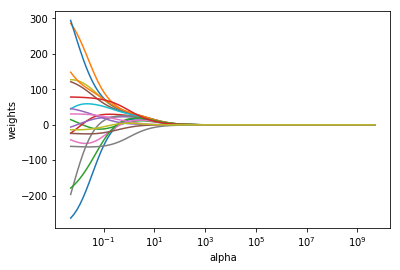

In [8]:
ridge = Ridge(normalize = True)
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)
    
np.shape(coefs)
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [9]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)
ridge.set_params(alpha=ridgecv.alpha_)
ridge.fit(X_train, y_train)
print(pd.Series(ridge.coef_, index=X.columns))
print("\nThe optimal value of alpha: ")
print(ridgecv.alpha_)

AtBat           -1.694159
Hits             5.748560
HmRun           -2.405052
Runs             0.386345
RBI              0.921447
Walks            4.208601
Years           -6.624974
CAtBat          -0.073595
CHits            0.219630
CHmRun           1.195829
CRuns            0.540297
CRBI             0.300901
CWalks          -0.453995
PutOuts          0.298730
Assists          0.028026
Errors           1.708683
League_N        39.181406
Division_W    -117.511754
NewLeague_N      4.625766
dtype: float64

The optimal value of alpha: 
0.01155064850041579


## Problem 2

Short Answer. Explain in your own words the bias-variance tradeoff. What role does regularization play in this tradeoff? Make reference to your findings in number (1) to describe models of high/low bias and variance.

#### Model 1 with 13 predictors:

In [41]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
print("Alpha:")
print(lassocv.alpha_)
print("Train Error:")
print(mean_squared_error(y_train, lasso.predict(X_train)))
print("Test Error:")
print(mean_squared_error(y_test, lasso.predict(X_test)))

Alpha:
0.24258426098354494
Train Error:
89891.98469333121
Test Error:
124976.51724991493


#### Model 2 with 11 predictors:

In [48]:
lasso.set_params(alpha=0.6)
lasso.fit(X_train, y_train)
print("Alpha:")
print("0.6")
print("Train Error:")
print(mean_squared_error(y_train, lasso.predict(X_train)))
print("Test Error:")
print(mean_squared_error(y_test, lasso.predict(X_test)))
# print(pd.Series(lasso.coef_, index=X.columns))

Alpha:
0.6
Train Error:
97222.86435373912
Test Error:
130366.205346681


#### Model 3 with 18 predictors:

In [47]:
lasso.set_params(alpha=0.01)
lasso.fit(X_train, y_train)
print("Alpha:")
print("0.01")
print("Train Error:")
print(mean_squared_error(y_train, lasso.predict(X_train)))
print("Test Error:")
print(mean_squared_error(y_test, lasso.predict(X_test)))
#print(pd.Series(lasso.coef_, index=X.columns))

Alpha:
0.01
Train Error:
85277.54259098653
Test Error:
132771.4582471132


### Bias-variance tradeoff: 
If our model is too simple and has very few parameters then it may have high bias and low variance. This kind of model may have the problem of underfitting. On the other hand if our model has large number of parameters then it’s going to have high variance and low bias. And in this case, there would be overfitting problem. So we need to find the right/good balance without overfitting and underfitting the data.
This tradeoff in complexity is why there is a tradeoff between bias and variance. An algorithm can’t be more complex and less complex at the same time.

From the example of problem 1, we can illustrate that when alpha is smaller, we have a model with more predictors and also with lower train error. However, when alpha is 0.01 which generate a model with 18 predictors has the largest test error, there is a significant gap between test error and training error. Therefore, there would be a problem of overfittinng. And when alpha is optimal, we have the smallest test error among the three models, which means that model 1 is more optimal than model three.